# 2D ring resonator

To run this notebook from your browser, click [this link](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/a86bc42d97aceaf6ad31b83f14408bd808e38795?urlpath=lab%2Ftree%2Fdocs%2Fsource%2Fnotebooks%2FRingResonator.ipynb).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 1 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform each simulation in just a few minutes.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

Using Tidy3D credentials from stored file


## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# resolution
dl = 0.01

# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

# set number of PMLs on each side
npml = 15

In [3]:
# define pulse parameters
lambda0 = 1.0
freq0 = td.C_0 /lambda0
fwidth =  freq0 / 6
grids_per_wavelength = lambda0 / dl
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.Medium.html#tidy3d-medium)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.Structure.html)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

In [6]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
)

mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, freq=freq0)
mode_data = mode_solver.solve(mode_spec=td.ModeSpec(num_modes=2))

mode_data_0, mode_data_1 = mode_data

mode_data_0.field_data.Ey

<xarray.Tidy3dDataArray (x: 1, y: 201, z: 1, f: 1)>
array([[[[-3.45793527e-15-3.28290213e-15j]],

 [[-3.89535742e-15-3.59239220e-15j]],

 [[-3.91394721e-15-3.70032441e-15j]],

 [[-3.23969996e-15-2.28962347e-15j]],

 [[-2.73158399e-15-3.88524378e-16j]],

 [[-2.89746467e-15-5.91376834e-16j]],

 [[-2.38563462e-15+7.49619790e-16j]],

 [[-1.60102121e-15+2.44517689e-16j]],

 [[-4.14802873e-16+1.94491991e-15j]],

 [[-2.82650857e-16+1.86820040e-15j]],

...

 [[-2.11248278e-15-8.40114590e-16j]],

 [[-2.69034804e-15+6.12527960e-16j]],

 [[-2.48506951e-15+6.56685719e-17j]],

 [[-1.61640349e-15+4.35321452e-16j]],

 [[-1.39814099e-15-4.90267920e-16j]],

 [[-1.02556428e-15-5.79381675e-16j]],

 [[-1.95129349e-15-6.94572169e-16j]],

 [[-2.39224370e-15-1.17009926e-15j]],

 [[-2.33320448e-15-2.01495668e-15j]],

 [[-1.32879353e-15-2.22012091e-15j]]]])
Coordinates:
 * x (x) float64 -5.5
 * y (y) float64 2.795 2.805 2.815 2.825 ... 4.765 4.775 4.785 4.795
 * z (z) float64 -0.005
 * f (f) float64 2.998e+14 xarray.Tidy3dDataArray x : 1 y : 201 z : 1 f : 1 (-3.4579352732548283e-15-3.2829021342530885e-15j) ... (-1.328793528... array([[[[-3.45793527e-15-3.28290213e-15j]],

 [[-3.89535742e-15-3.59239220e-15j]],

 [[-3.91394721e-15-3.70032441e-15j]],

 [[-3.23969996e-15-2.28962347e-15j]],

 [[-2.73158399e-15-3.88524378e-16j]],

 [[-2.89746467e-15-5.91376834e-16j]],

 [[-2.38563462e-15+7.49619790e-16j]],

 [[-1.60102121e-15+2.44517689e-16j]],

 [[-4.14802873e-16+1.94491991e-15j]],

 [[-2.82650857e-16+1.86820040e-15j]],

...

 [[-2.11248278e-15-8.40114590e-16j]],

 [[-2.69034804e-15+6.12527960e-16j]],

 [[-2.48506951e-15+6.56685719e-17j]],

 [[-1.61640349e-15+4.35321452e-16j]],

 [[-1.39814099e-15-4.90267920e-16j]],

 [[-1.02556428e-15-5.79381675e-16j]],

 [[-1.95129349e-15-6.94572169e-16j]],

 [[-2.39224370e-15-1.17009926e-15j]],

 [[-2.33320448e-15-2.01495668e-15j]],

 [[-1.32879353e-15-2.22012091e-15j]]]]) Coordinates: (4) x (x) float64 -5.5 units : um long_name : x position array([-5.5]) y (y) float64 2.795 2.805 2.815 ... 4.785 4.795 units : um long_name : y position array([2.795, 2.805, 2.815, ..., 4.775, 4.785, 4.795]) z (z) float64 -0.005 units : um long_name : z position array([-0.005]) f (f) float64 2.998e+14 units : Hz long_name : frequency array([2.997925e+14]) Attributes: (0)

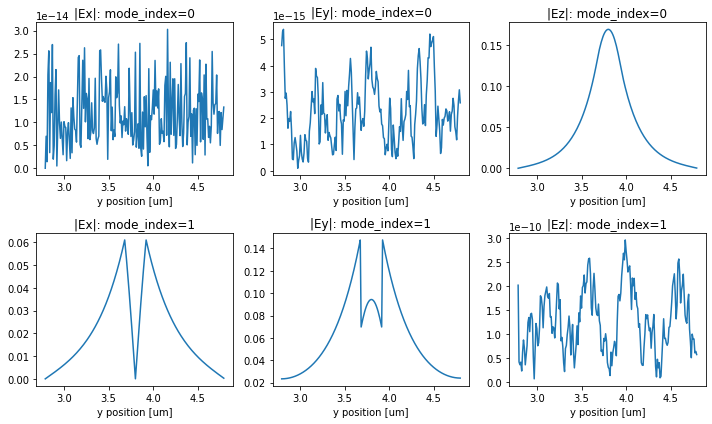

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
abs(mode_data_0.field_data.Ex).plot(ax=ax1)
abs(mode_data_0.field_data.Ey).plot(ax=ax2)
abs(mode_data_0.field_data.Ez).plot(ax=ax3)
abs(mode_data_1.field_data.Ex).plot(ax=ax4)
abs(mode_data_1.field_data.Ey).plot(ax=ax5)
abs(mode_data_1.field_data.Ez).plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [8]:
# mode_source = mode_solver.to_source(mode_spec=td.ModeSpec(num_modes=2), fwidth=fwidth, direction="+")
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+'
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(0.8, 1.1, 1001)
freqs_measure = td.C_0 / lambdas_measure
# mode_monitor = mode_solver.to_monitor(mode=td.Mode(mode_index=1), freqs=freqs_measure, name='mode')
mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor.center = [+wg_insert_x, wg_center_y, 0]

Define simulation. [(docs)](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.Simulation.html)

Here, we turn off the automatic shutoff factor by setting it to 0. This is because we will compute the spectrum by a fourier transform of the time response, and we would like to run the normalization simulation and the simulation with ring to exactly the same `run_time`.

In [10]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time_norm,
    pml_layers=[td.PML(), td.PML(), None])

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    pml_layers=[td.PML(), td.PML(), None])

----
Visualize structure, source, and modes. [(docs)](https://docs.simulation.cloud/en/latest/howdoi.html#plot-data)

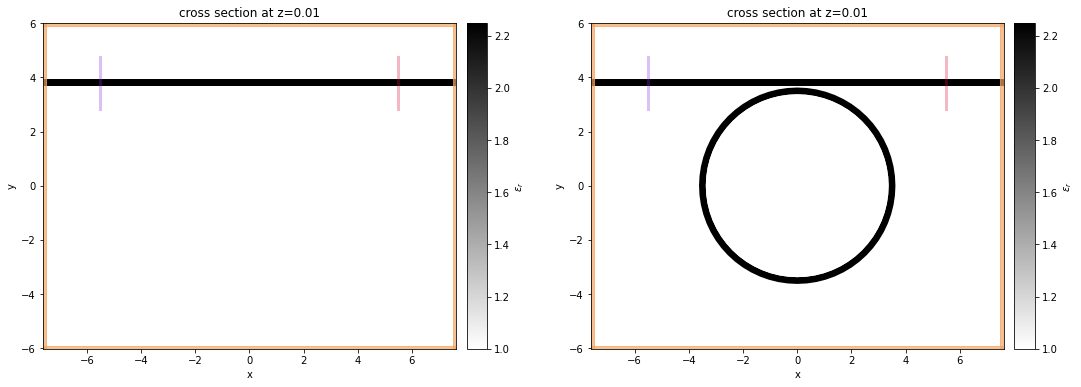

In [11]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://docs.simulation.cloud/en/latest/api.html#submitting-simulations)

In [12]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

[20:49:38] INFO     Uploaded task 'normalization' with task_id                  ]8;id=230993;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=199012;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '0b704293-3243-43cb-ac69-58b0775b66b8'.

Output()

[20:49:39] status = queued                                                      ]8;id=950908;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=884115;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:49:52] status = preprocess                                                  ]8;id=641429;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=531622;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:50:12] status = running                                                     ]8;id=600884;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=369323;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:50:30] status = postprocess                                                 ]8;id=513791;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=900206;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:51:25] status = visualize                                                   ]8;id=147835;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=455394;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:51:56] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=377644;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=875613;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#481\481]8;;\
                    "data/simulation_data0.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[20:52:22] INFO     loading SimulationData from data/simulation_data0.hdf5      ]8;id=155246;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=528292;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

[20:52:25] INFO     Uploaded task 'with_ring' with task_id                      ]8;id=572769;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=852660;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    '44bbf611-a203-4323-b767-bfa67974d682'.

Output()

[20:52:26] status = queued                                                      ]8;id=640247;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=786878;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:53:02] status = running                                                     ]8;id=600887;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=567780;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:54:16] status = postprocess                                                 ]8;id=42602;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=199164;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:56:11] status = visualize                                                   ]8;id=476319;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=497566;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:56:28] status = success                                                     ]8;id=458255;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=548568;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#200\200]8;;\

[20:56:28] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=209453;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=806741;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#481\481]8;;\
                    "data/simulation_data.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[20:56:53] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=653989;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=236069;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

In [13]:
print(sim_data.log)

Simulation domain Nx, Ny, Nz: [1524, 1204, 1]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.8349e+06.
Using subpixel averaging: True
Number of time steps: 2.8848e+05
Automatic shutoff factor: 1.00e-05
Time step (s): 1.7332e-17
Compute source modes time (s):     0.3360
Compute monitor modes time (s):    14.2797

Rest of setup time (s):            0.7047

Starting solver...
- Time step    919 / time 1.59e-14s (  0 % done), field decay: 1.00e+00
- Time step  11539 / time 2.00e-13s (  4 % done), field decay: 2.73e-03
- Time step  23078 / time 4.00e-13s (  8 % done), field decay: 2.97e-05
- Time step  34617 / time 6.00e-13s ( 12 % done), field decay: 5.83e-07
Field decay smaller than shutoff factor, exiting solver.

Solver time (s):                   44.7916
Post-processing time (s):          64.3790



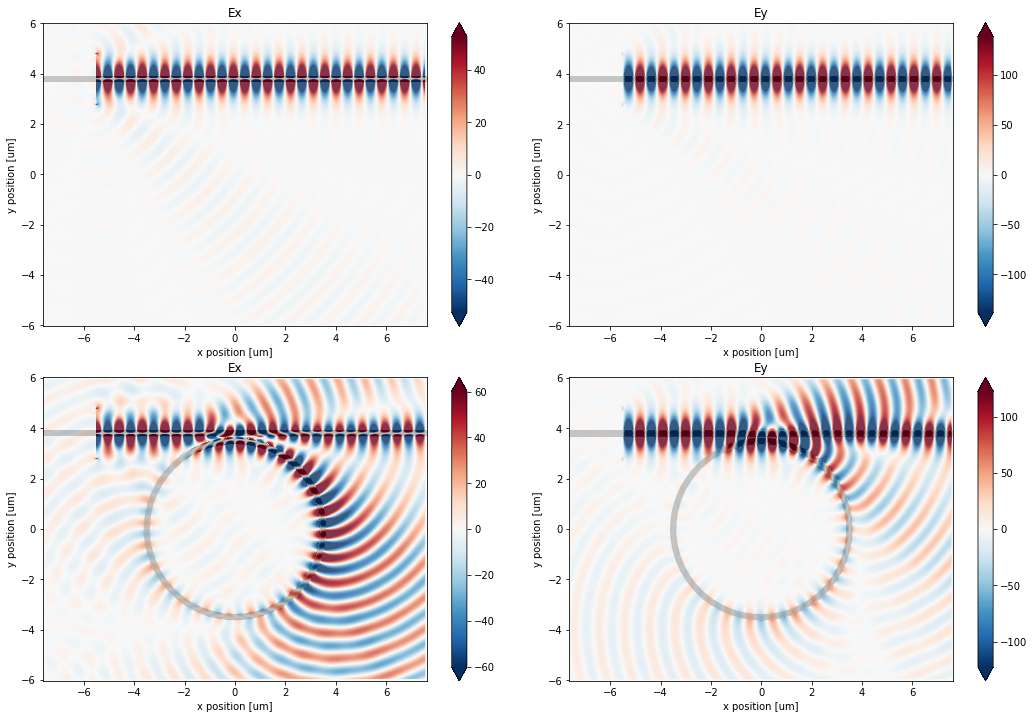

In [14]:
# visualize normalization run
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(15, 10))

ax1 = sim_data0.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax1)
ax2 = sim_data0.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax2)
ax1.set_title('Ex')
ax2.set_title('Ey')

ax3 = sim_data.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax3)
ax4 = sim_data.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax4)
ax3.set_title('Ex')
ax4.set_title('Ey')

plt.show()

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [15]:
sim_data['mode']

ModeData(type='ModeData', data_dict={'amps': ModeAmpsData(type='ModeAmpsData', values=array([[[-5.18933392e-06-9.28853579e-07j,
         -5.91446486e-06+7.15100460e-07j,
         -6.35469572e-06+2.59333167e-06j, ...,
          3.98401788e-05+3.80148587e-05j,
          4.01712266e-05+3.65385415e-05j,
          4.04556390e-05+3.51166446e-05j],
        [-5.08592725e-01-1.67117527e-01j,
         -5.37546006e-01-1.50367531e-01j,
         -5.65353261e-01-1.28863242e-01j, ...,
         -5.95045473e-01+3.52746282e-01j,
         -5.87168735e-01+3.65501021e-01j,
         -5.79033441e-01+3.78080569e-01j]],

       [[-1.33128564e-08-1.22367482e-08j,
         -9.81879747e-09-1.26031148e-08j,
         -6.31947386e-09-1.54291838e-08j, ...,
          1.40826718e-07-2.07321383e-07j,
          1.36254405e-07-2.11319487e-07j,
          1.31853521e-07-2.14831285e-07j],
        [-8.58426239e-05+4.58413297e-05j,
         -8.61544457e-05+5.18981808e-05j,
         -8.16808388e-05+5.15701199e-05j, ...,
         -5.05546888e-04+2.17557788e-04j,
         -4.99413661e-04+2.32233778e-04j,
         -4.94459485e-04+2.42746200e-04j]]]), data_attrs={'units': 'sqrt(W)', 'long_name': 'mode amplitudes'}, f=array([3.74740573e+14, 3.74600098e+14, 3.74459728e+14, ...,
       2.72687337e+14, 2.72612948e+14, 2.72538599e+14]), mode_index=array([0, 1]), direction=['+', '-']), 'n_complex': ModeIndexData(type='ModeIndexData', values=array([[1.27235709+4.99550046e-18j, 1.27227589-1.55449342e-17j,
        1.27219471-2.19012994e-18j, ..., 1.20234572+1.30201582e-17j,
        1.2022856 -1.57040223e-17j, 1.2022255 -9.90524258e-19j],
       [1.15597591+2.75460004e-11j, 1.1558739 +2.78021364e-11j,
        1.15577198+2.80594458e-11j, ..., 1.08791287+8.65357480e-12j,
        1.08787214+8.63849301e-12j, 1.08783145+8.62317390e-12j]]), data_attrs={'units': 'None', 'long_name': 'complex effective index'}, f=array([3.74740573e+14, 3.74600098e+14, 3.74459728e+14, ...,
       2.72687337e+14, 2.72612948e+14, 2.72538599e+14]), mode_index=array([0, 1]))})

As we see, the mode amplitude data is complex-valued with three 3 dimensions:
* index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).
* direction of the propagation (for decomposition).
* frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency and divide the results with a ring by the normalization.

In [16]:
mode_data = sim_data['mode'].amps.sel(mode_index=1, direction='+')
mode_data0 = sim_data0['mode'].amps.sel(mode_index=1, direction='+')
transmission_amps = mode_data / mode_data0

Now let's plot the data.

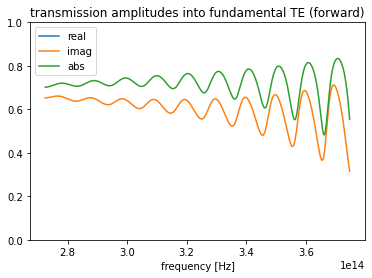

In [17]:
f, ax = plt.subplots()
transmission_amps.real.plot.line(x='f', ax=ax, label='real')
transmission_amps.imag.plot.line(x='f', ax=ax, label='imag')
abs(transmission_amps).plot.line(x='f', ax=ax, label='abs')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
ax.set_ylim(0, 1)
plt.show()

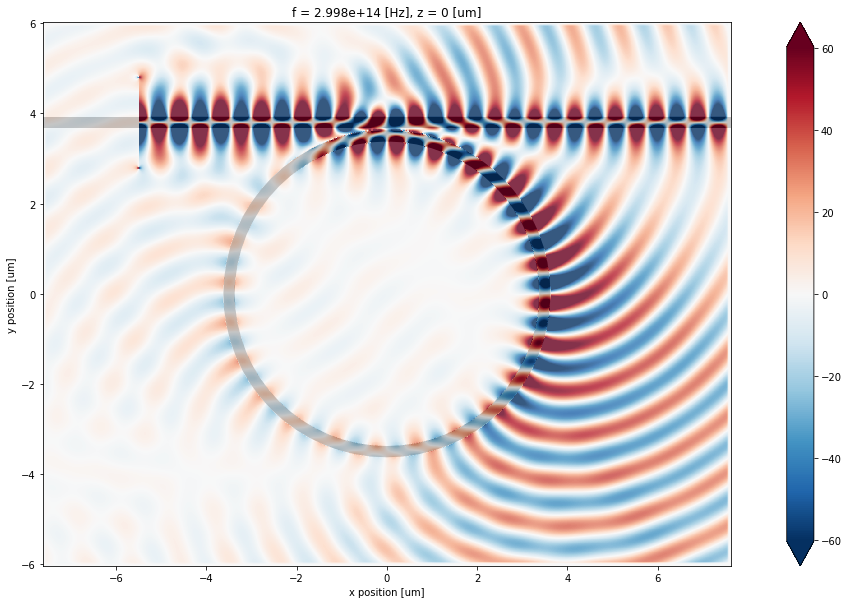

In [21]:
import matplotlib.pylab as pltf, ax = plt.subplots(figsize=(20, 10))
ax = sim_data.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax)
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')